#### Looking at performance of Individual group:

What fragments are found signicantly higher representation compared to the entire set?

How do the AIM vs Toxprints compare (are there more AIM / tox fragments found to be present in the group)

How is the performance of predictions (both good, one good, neither good)

<!-- 
#### Compare groups?:

Are there groups which have a similar distribution of fragments?  (More similar compounds. eg. the benz subclasses)

Of the groups that are similar, how do the predictions compare
 -->

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os


In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP +'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [3]:
df = pd.read_csv(processed_dir+'htpp_parsed_classyfire_data.csv')

## Load in Classyfire data 
 - This gives us an assigned class labels for each DTXSID so we can group our chemicals based on structural similarity
 

In [4]:
df.head()

,dtxsid,kingdom,superclass,class,subclass,substituents
0,DTXSID5020281,organic compounds,benzenoids,benzene and substituted derivatives,nitrobenzenes,nitrobenzene|nitroaromatic compound|chlorobenz...
1,DTXSID8020961,organic compounds,benzenoids,benzene and substituted derivatives,nitrobenzenes,nitrobenzene|nitroaromatic compound|aniline or...
2,DTXSID0021834,organic compounds,benzenoids,phenols,nitrophenols,nitrophenol|nitrobenzene|nitroaromatic compoun...
3,DTXSID2044347,organic compounds,organic oxygen compounds,organooxygen compounds,carbonyl compounds,alkyl-phenylketone|acetophenone|phenoxy compou...
4,DTXSID4025745,organic compounds,benzenoids,benzene and substituted derivatives,nitrobenzenes,nitrobenzene|nitroaromatic compound|benzyl hal...


Look at clusters (mean error) --> fragment distribution in individual cluster --> Errors of individual structures in cluster

In [5]:
df = df[['dtxsid','class','subclass']]

In [44]:
df.shape

(6932, 3)

## Create a table for our groups

We are interested in creating groups which contain enough chemicals but that are more distinct compared to the general chemical population

In [6]:
# Most CLASSES are fine, but some are too generalized so use SUBCLASSES when necessary

chem_classes = list(set([row for row in df['class']]))
chem_classes = [x for x in chem_classes if str(x) != 'nan']

grps = []
N_structs = []
for i in chem_classes:
    df2 = df[df['class'] == i]
    if len(df2) > 200: # If our class is too broad, (benz); want to use subclasses (more specified) instead
        subclasses = list(set([row for row in df2['subclass']]))  
        subclasses = [x for x in subclasses if str(x) != 'nan']
        for j in subclasses:
            df3 = df[df['subclass']==j]
            grps.append(j)
            N_structs.append(len(df3))
    else:
        grps.append(i)
        N_structs.append(len(df2))

df_lens = pd.DataFrame.from_dict(zip(grps,N_structs))
df_lens = df_lens.rename(columns={0:'Group',1:'N_struct'})


df_lens[df_lens['N_struct']>20]


,Group,N_struct
7,fatty acid esters,118
8,fatty acids and conjugates,52
13,fatty alcohols,30
16,organochlorides,33
19,triazines,53
...,...,...
317,organic cyanides,53
318,nitrogen mustard compounds,22
319,amines,238
320,quaternary ammonium salts,36


We end up with 88 different groups, currently the only information included is the number of chemicals per group.

Next, we want to pull additional information for each group

## Join dataframes

We want to include all necessary information in a single table (aim,toxprints,classes)

In [7]:
txp_predictions = pd.read_csv(processed_dir+'txp_predictions_genra.csv')

In [8]:
aim_predictions = pd.read_csv(processed_dir+'aim_predictions_genra.csv')

In [9]:
aim_predictions = aim_predictions.drop(['Unnamed: 0'] , axis =1)

In [10]:
txp_predictions = txp_predictions.drop(['Unnamed: 0'] , axis =1)

In [11]:
txp_predictions = txp_predictions[['Y_true', 'Y_pred', 'Diff', 'dtxsid', 'txp_list']]

In [12]:
aim_predictions = aim_predictions[['Y_true', 'Y_pred', 'Diff', 'dtxsid', 'aim_list']]

In [13]:
df3 = pd.merge(aim_predictions,txp_predictions,how='inner',on='dtxsid')

In [14]:
df3 = pd.merge(df,df3,how='inner',on='dtxsid')
df3 = df3.rename(columns={'Y_pred_x':'Y_pred_aim','Diff_x':'Diff_aim','Y_pred_y':'Y_pred_tox','Diff_y':'Diff_tox'})

In [15]:
df3 = df3.drop(columns = 'Y_true_x')

In [16]:
df3.rename(columns = {'Y_true_y': 'Y_true', 'txp_list': 'tox_list'}, inplace = True)

In [17]:
df3.head(1)

,dtxsid,class,subclass,Y_pred_aim,Diff_aim,aim_list,Y_true,Y_pred_tox,Diff_tox,tox_list
0,DTXSID5020281,benzene and substituted derivatives,nitrobenzenes,-0.329968,0.135371,"['Aromatic Carbon', ' CL [chlorine, aromatic a...",-0.465339,-0.346871,0.118469,"['bond:CX_halide_aromatic-X_generic', 'bond:N(..."


In [18]:
df3.name = 'full'

In [5]:
'''df_tox = pd.read_pickle('../Inputs/toxprint_5_11_22.pkl')
df_tox = df_tox.reset_index()
df_tox = df_tox.rename(columns={'index':'dtxsid'})

df_aim = pd.read_pickle('../Inputs/aim_5_11_22.pkl')
df_aim = df_aim.reset_index()
df_aim = df_aim.drop(columns=['Y_true'])
df_aim= df_aim.rename(columns={'index':'dtxsid'})


df3 = pd.merge(df_aim,df_tox,how='inner',on='dtxsid')
df3 = pd.merge(df,df3,how='inner',on='dtxsid')
df3 = df3.rename(columns={'Y_pred_x':'Y_pred_aim','Diff_x':'Diff_aim','Y_pred_y':'Y_pred_tox','Diff_y':'Diff_tox'})
df3.to_pickle('df_combined.pkl')
df3.name = 'full'
df3.head(1)

,dtxsid,class,subclass,Y_pred_aim,Diff_aim,aim_list,Y_true,Y_pred_tox,Diff_tox,tox_list
0,DTXSID5020281,benzene and substituted derivatives,nitrobenzenes,-0.329968,0.135371,"[Aromatic Carbon, CL [chlorine, aromatic atta...",-0.465339,-0.27942,0.18592,"[bond:CX_halide_aromatic-X_generic, bond:N(=O)..."


## Calculate stats for each group

With the above created dataframe, we can now calculate additional stats for each group 

In [19]:
from sklearn.metrics import r2_score

def class_errors(df):
    diffs = []
    for i in grps:
        if i in chem_classes:
            df2 = df[df['class'] == i]
        else:
            df2 = df[df['subclass'] == i]

        err_tox = df2['Diff_tox'].mean()
        err_aim = df2['Diff_aim'].mean()
        true = df2['Y_true'].mean()
        true_range = df2['Y_true'].max()-df2['Y_true'].min()


        num = len(df2['Diff_tox'])
        if num > 20:
            perf_tox =  r2_score(df2['Y_true'],df2['Y_pred_tox'])
            perf_aim =  r2_score(df2['Y_true'],df2['Y_pred_aim'])
        else: 
            perf_tox=0
            perf_aim = 0
        diffs.append([err_tox,err_aim,true,true_range,num,perf_tox,perf_aim])
        
    df3 = pd.DataFrame.from_dict(dict(zip(grps,diffs))).T
    return df3

In [20]:
df_grps = class_errors(df3)
df_grps = df_grps.rename(columns={0:'Error_tox',1:'Error_aim',2:'True',3:'True_range',4:'N Struc',5:'r2_tox',6:'r2_aim'})
df_grps = df_grps[df_grps['N Struc'] > 20].copy()
df_grps['diff_err'] = df_grps['Error_tox'] -df_grps['Error_aim']

#df_grps.to_pickle('grp_df.pkl')
df_grps.sort_values(by=['diff_err'])

## We see that the biggest gaps in performance are the following groups:
## Toxprint Outperorms:
    ## alpha-halocarboxylic acids and derivatives (0.33)
    ## carbohydrates and carbohydrate conjugates   (0.24)
## AIM Outperforms
    ## isoindoles and derivatives (0.21)
    ## Benzodioxoles       (0.15)


,Error_tox,Error_aim,True,True_range,N Struc,r2_tox,r2_aim,diff_err
alpha-halocarboxylic acids and derivatives,0.607868,0.932742,-0.382454,4.707719,21.0,0.377178,-0.421278,-0.324874
trifluoromethylbenzenes,0.469786,0.713086,-0.511234,2.818646,32.0,0.081392,-1.424368,-0.243300
carbohydrates and carbohydrate conjugates,0.454338,0.660842,-1.047618,4.117472,28.0,0.508123,0.022958,-0.206504
organic dithiophosphoric acids and derivatives,0.735490,0.931329,0.560882,4.354751,44.0,0.529655,0.176486,-0.195839
benzenesulfonic acids and derivatives,0.305711,0.473257,-1.107290,1.588678,26.0,0.257307,-0.316190,-0.167546
...,...,...,...,...,...,...,...,...
benzenesulfonyl compounds,0.591777,0.515636,-0.605603,3.363983,21.0,0.475840,0.522705,0.076142
organic thiophosphoric acids and derivatives,0.745701,0.652578,0.448417,4.502745,99.0,-0.129169,0.192026,0.093123
thioethers,0.683818,0.569910,-0.335817,4.117858,51.0,0.084105,0.315603,0.113908
isoindoles and derivatives,0.746103,0.610287,-0.377211,3.372632,27.0,0.141279,0.328820,0.135816


The above table contains information for each of the 88 groups found by

## PLotting group distribution

We want to see how variable toxicity of chemicals in our groups are

If a group contains similar structures, then it should have a smaller range

In [21]:
def plot_grps_dist(df):
    data = []
    for i in grps:
        if i in chem_classes:
            df2 = df[df['class']==i]
        else:
            df2 = df[df['subclass']==i]
        if len(df2) > 20:
            Y_range = df2['Y_true'].max()-df2['Y_true'].min()
            data.append([df2['Y_true'],Y_range,len(df2)])
    fig, ax = plt.subplots(figsize=(30,9))
    df = pd.DataFrame.from_dict(dict(zip(grps,data))).T
    df = df.sort_values(by=[1])
    df = df.rename(columns={0:'data',1:'range',2:'num_struc'})

    ax.boxplot(df['data'])
    plt.show()
        
    return df



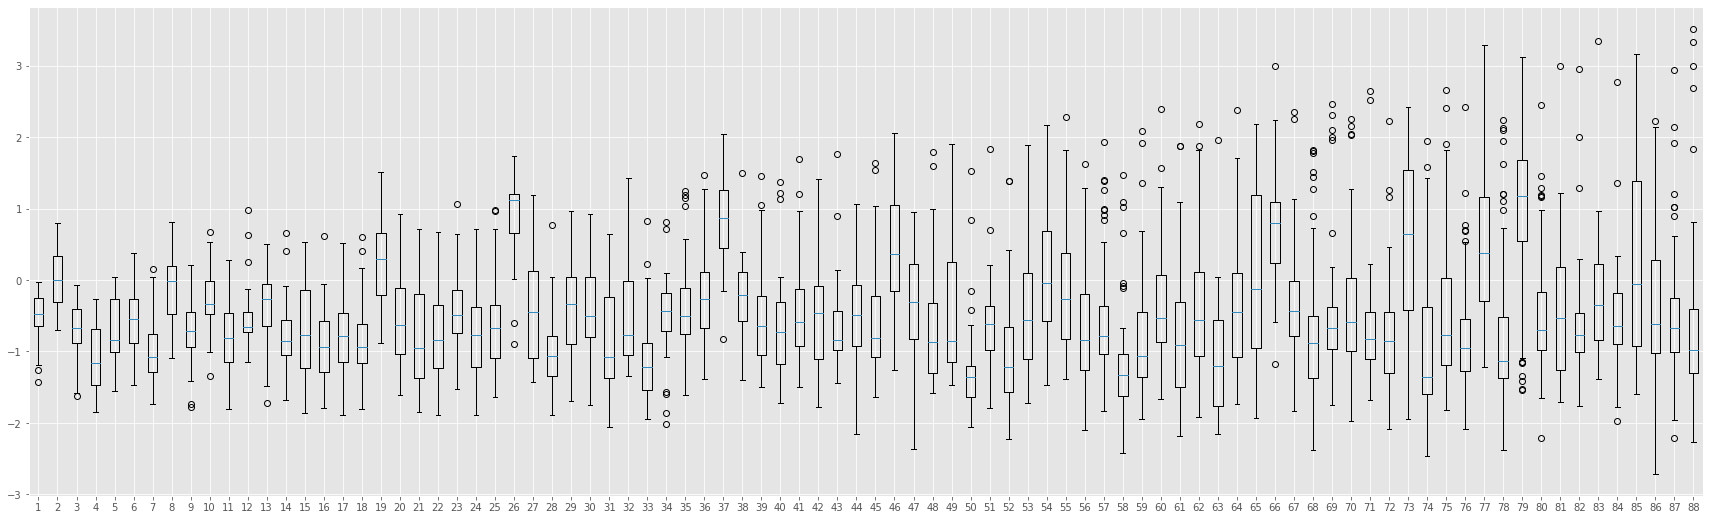

In [22]:
df_dist = plot_grps_dist(df3)

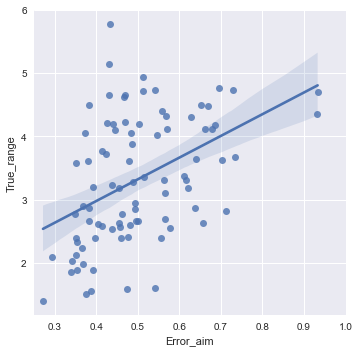

In [23]:
# Plotting the range vs the error to see if there is any relationship

plt.style.use('seaborn')

g = sns.lmplot(x='Error_aim',y='True_range',data=df_grps)
g.set(xlim=(0.25,1))
# plt.ylabel('Toxicity Range')
# plt.xlabel('Error Tox')
# plt.title('Classes and Errors')

## Visualize the errors
We want to find out if there are any classes which one fingerprint set signficantly outperforms the other

Text(0.5, 1.0, 'Classes and Errors')

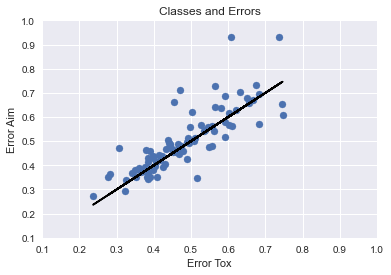

In [24]:
plt.style.use('seaborn')
X = df_grps['Error_tox']
Y = df_grps['Error_aim']
plt.figure(figsize=(6,4))
plt.plot(X,X,color='black')
plt.scatter(X,Y)
plt.ylim([0.1,1])
plt.xlim([0.1,1])
plt.ylabel('Error Aim')
plt.xlabel('Error Tox')
plt.title('Classes and Errors')

We see a positive correlation of performance between the two feature sets. 

Some are "well-predicted" (<0.4) while other groups are poorly predicted (>0.6)

Not a significant difference in performance between the fingerprint sets for majority of groups

In [25]:
from collections import Counter
import numpy as np
def frag_freq(df,col_name):
    fragments = []
    for row in df[col_name]:  
        for fragment in row:
            fragments.append(fragment)

    frequency = Counter(fragments)

    for item, count in frequency.items():
        frequency[item] = np.round(frequency[item],3)
    
    df = pd.DataFrame.from_dict(frequency, orient='index', columns=[df.name])
    return df

In [26]:
import functools

def freq_table(col_name):
    df_full = frag_freq(df3,col_name)

    dfs = [df_full]
    group_counts = [len(df3)]
    for i in grps:
        if i in chem_classes:
            df_label_i = df3[df3['class'] == i]
        else:
            df_label_i = df3[df3['subclass'] == i]
        if len(df_label_i) > 10:
            group_counts.append(len(df_label_i))
            df_label_i.name = i
            df_label = frag_freq(df_label_i,col_name)
            dfs.append(df_label)

    df = functools.reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='outer'),dfs)
    df.loc[len(df)] = group_counts
    df = df.rename(index = {(len(df)-1):"count"})
    df = df.fillna(0)
    return df

In [27]:
df_tox = freq_table('tox_list')
df_aim = freq_table('aim_list')

### Comparing the distribution of features between the full set and a subset based on structure

We choose the group "alpha-halocarboxylic acids and derivatives" because it has the largest difference in predictive performance between the two fragment sets

With this, we can see how different the structures are (feature-wise) when compared to the full sets

In [28]:
import matplotlib.pyplot as plt

def plot_freq_comparison(df,grp):
    df2 = df.copy()
    df = df/df.iloc[-1]
    df = df.iloc[:-1]
    #df = df[df[grp]>0.05]
    X = df['full']
    Y = df[grp]
    fig, ax = plt.subplots()
    ax.plot(X,X,color='black')
    ax.scatter(X,Y,label=grp)
    ax.set_xlabel('full')
    ax.set_ylabel('class')
    ax.legend()
    plt.show()

    return df2[[grp,'full']].rename(columns={grp:'grp'})

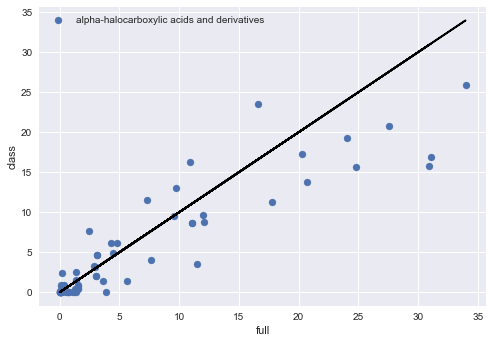

In [29]:
df_freq_tox = plot_freq_comparison(df_tox,'alpha-halocarboxylic acids and derivatives')

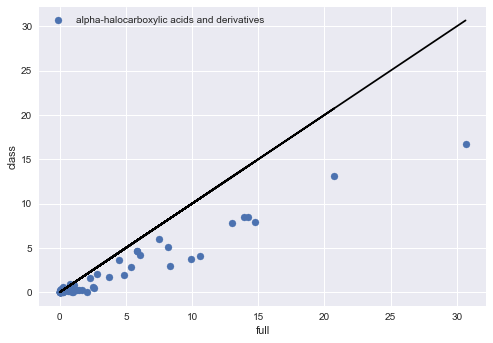

In [30]:
df_freq_aim = plot_freq_comparison(df_aim,'alpha-halocarboxylic acids and derivatives')

The two figures above demonstrate the difference in fragment presence between the individual group and the full data set.

Above the black line = Larger fraction of structures contained this fragment in the group compared to full set

Below the line = Smaller fraction


In [31]:
classified = df_grps['N Struc'].sum()
N_unclassified = int(df.shape[0] - classified)

# Due to how the groups were chosen (we exclude those grps with less than 20),

print(f'There are {N_unclassified} unclassified chemicals')

There are 1462 unclassified chemicals


## Further Investigation:Looking at the individual error differences for the specific group of interest

- Are there any outliers?
- or Consistent trend?

Text(0.5, 1.0, 'alpha-halocarboxylic acids and derivatives Errors')

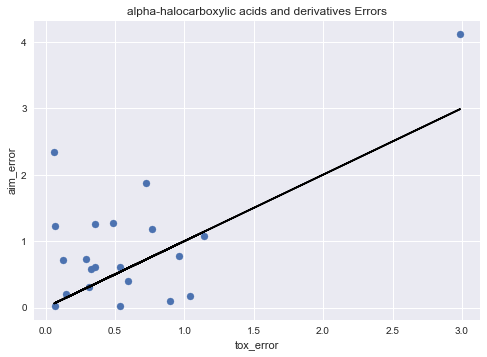

In [32]:
grp_name = 'alpha-halocarboxylic acids and derivatives'

grp_dataset = df3[df3['class']==grp_name]
if len(grp_dataset) == 0:
    grp_dataset = df3[df3['subclass']==grp_name]

X = grp_dataset['Diff_tox']
Y = grp_dataset['Diff_aim']

plt.scatter(X,Y)
plt.plot(X,X,color='black')
plt.xlabel('tox_error')
plt.ylabel('aim_error')
plt.title('alpha-halocarboxylic acids and derivatives Errors')

## Toxicity vs Similarity plot

Since our chemicals are predicted by nearest neighbors, we want to see why predictions are bad/good



In [33]:
# Getting a list of our groups
grps = df_grps.index.to_list()

df3['Diff_errs'] = df3['Diff_tox']-df3['Diff_aim']
df3[df3['class']=='isoindoles and derivatives'].sort_values(by=['Diff_errs']).head(1)

,dtxsid,class,subclass,Y_pred_aim,Diff_aim,aim_list,Y_true,Y_pred_tox,Diff_tox,tox_list,Diff_errs
3916,DTXSID9022524,isoindoles and derivatives,isoindolines,-1.091156,1.45009,"[' CH2 [aliphatic carbon]', ' CH [aliphatic ca...",0.358933,-0.446752,0.805685,"['bond:C(=O)N_carboxamide_(NHR)', 'bond:C(=O)N...",-0.644405


## Using Jaccard Similarity
$$
  J(A,B) = \frac{|A \cap B|}{|A \cup B|}
$$


We can calculate jaccard for a given structure by comparing the two lists of features

(N shared features by both) / (total features between both structures)

In [34]:
# Get jaccard just gives us the 
def get_jaccard(lst_0,lst_1):
    a = [item for item in lst_0 if item in lst_1]   # Features shared byBoth 
    b = [item for item in lst_0 if item not in lst_1] # Features in Struct 1 only
    c = [item for item in lst_1 if item not in lst_0] # Features in Struct 2 only

    jaccard = len(a)/(len(a)+len(b)+len(c))
    
    return jaccard

def all_jaccards(N,df,fp_set):
    lst_0 = df[f'{fp_set}_list'].iloc[[N]][N]

    data = []
    for i,row in df[[f'{fp_set}_list']].iterrows():
        lst_1 = df[f'{fp_set}_list'].iloc[[i]][i]
        jac = get_jaccard(lst_0,lst_1)
        if df.iloc[[N]]['class'][N] in grps:
            grp = df.iloc[[i]]['class'][i]
        else:
            grp = df.iloc[[i]]['subclass'][i]
        data.append([jac,grp])
    dfj = pd.DataFrame(data)
    dfj.name = N
    
    return dfj, N


def make_plot(N,df,fp_set):
    df2, N = all_jaccards(N,df,fp_set)
    df_n = pd.merge(df,df2,how='outer',left_index=True,right_index=True)
    df_n = df_n.rename(columns={0:f'row {N} Similarity',1:'group'})
    
    X = df_n[f'row {N} Similarity'][1:]
    Y = df_n['Y_true'][1:]

    grp = df_n.iloc[[N]]['group'][N] 
    df_n_sub = df_n[df_n['group']==grp]

    X3 =  df_n[f'row {N} Similarity'][N:N+1]
    Y3 = df_n['Y_true'][N:N+1]

    plt.figure(figsize=(6,4))
    plt.scatter(X,Y,label='all')
    plt.scatter(X3,Y3,label='individual true',color='black')
    plt.axhline(y=df_n[f'Y_pred_{fp_set}'][N:N+1].iloc[0],color='red',label='predicted aim')
    plt.xlabel('Jaccard')
    plt.ylabel('Toxicity')
    plt.legend()
    return df_n

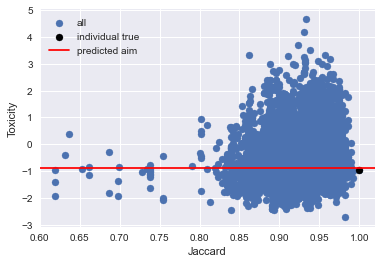

In [35]:
df_x = make_plot(1210,df3,'aim')
# Better prediction due to the nearest neighbors being close in toxicity

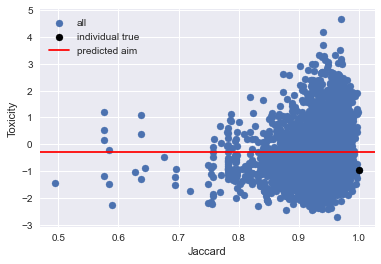

In [36]:
# Worse prediction due to the nearest neighbors being dissimilar in toxicity
df_x = make_plot(1210,df3,'tox')


### Process for selecting N (for above plot)

1. Select group of interest
2. Filter df3 by selecting chemicals only within group of interest
3. Select chemical in group of interest by some metric (error), the index number of that chemical is N

Text(0.5, 1.0, 'Classes and Errors')

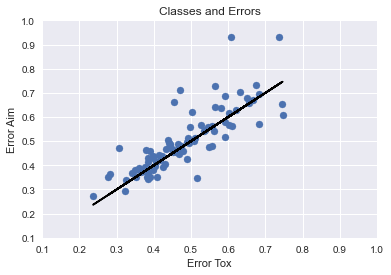

In [37]:
plt.style.use('seaborn')
X = df_grps['Error_tox']
Y = df_grps['Error_aim']
plt.figure(figsize=(6,4))
plt.plot(X,X,color='black')
plt.scatter(X,Y)
plt.ylim([0.1,1])
plt.xlim([0.1,1])
plt.ylabel('Error Aim')
plt.xlabel('Error Tox')
plt.title('Classes and Errors')

In [38]:
#1
group = df_grps.sort_values(by=['Error_tox']).index[0] #Group which has lowest abs error

#2
grp_dataset = df3[df3['class']==group]
if len(grp_dataset) == 0:
    grp_dataset = df3[df3['subclass']==group]
#3
num = grp_dataset.sort_values(by=['Diff_tox']).index[0] # smallest error in group

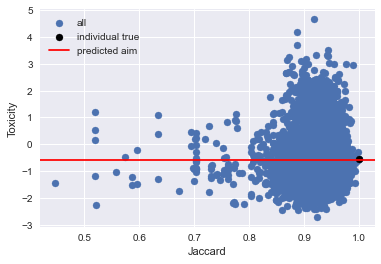

In [39]:
df_x = make_plot(num,df3,'tox')


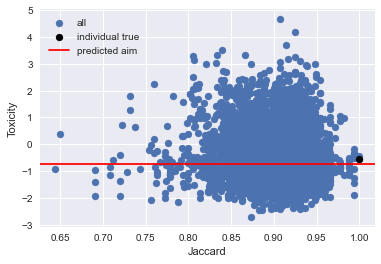

In [40]:
df_x = make_plot(num,df3,'aim')


In [41]:
#1
group = df_grps.sort_values(by=['Error_tox'],ascending=False).index[0] #Group which has LARGEST abs error

#2
grp_dataset = df3[df3['class']==group]
if len(grp_dataset) == 0:
    grp_dataset = df3[df3['subclass']==group]
#3
num = grp_dataset.sort_values(by=['Diff_tox'],ascending=False).index[0] # LARGEST error in group

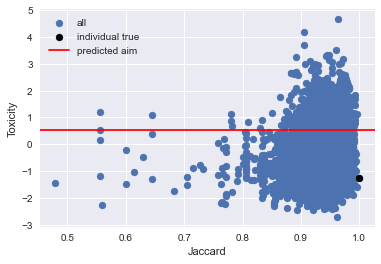

In [42]:
df_x = make_plot(num,df3,'tox')


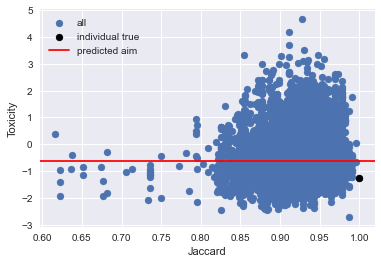

In [43]:
df_x = make_plot(num,df3,'aim')
